### Random Forests and Photo-zs

In this notebook, we use Random Forests to estimate photometric redshifts starting from observations of galaxy magnitudes in six different photometric bands (u, g, r, i, z, y). It is adapted from a notebook written for Chapter 6 of the book.

Essentially, we try to reproduce/improve upon the results of [this paper](https://arxiv.org/abs/1903.08174), for which the data are public and available [here](http://d-scholarship.pitt.edu/36064/).

Author: Viviana Acquaviva

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 100)


font = {'size'   : 16}
matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
matplotlib.rcParams.update({'figure.autolayout': False})
matplotlib.rcParams['figure.dpi'] = 300

In [2]:
from sklearn import metrics
from sklearn.model_selection import cross_validate, KFold, cross_val_predict, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [3]:
import astropy

from astropy.io import fits

#fits stands for Flexible Image Transport System; it's a format that allows one to store images and summary data

Data import

It's easiest IMO to read the data into a data frame using pandas:

In [4]:
with fits.open('DEEP2_uniq_Terapix_Subaru_v1.fits') as data:
    df = pd.DataFrame(np.array(data[1].data).byteswap().newbyteorder()) #see https://numpy.org/devdocs/user/basics.byteswapping.html#changing-byte-ordering

In [5]:
df.columns

Index(['objno_deep2', 'ra_deep2', 'dec_deep2', 'magb', 'magr', 'magi', 'pgal',
       'sfd_ebv', 'class', 'subclass', 'objname', 'maskname', 'slitname',
       'date', 'mjd', 'z_raw', 'zhelio', 'z_err', 'rchi2', 'dof', 'vdisp',
       'vdisp_err', 'zquality', 'egsflags', 'comment', 'm_b', 'ub_0',
       'ra_cfhtls', 'dec_cfhtls', 'u', 'g', 'r', 'i', 'i2', 'z', 'uerr',
       'gerr', 'rerr', 'ierr', 'i2err', 'zerr', 'u_apercor', 'g_apercor',
       'r_apercor', 'i_apercor', 'i2_apercor', 'z_apercor', 'uerr_aper',
       'gerr_aper', 'rerr_aper', 'ierr_aper', 'i2err_aper', 'zerr_aper',
       'uerr_apercor', 'gerr_apercor', 'rerr_apercor', 'ierr_apercor',
       'i2err_apercor', 'zerr_apercor', 'r_radius_arcsec', 'u(sexflag)',
       'g(sexflag)', 'r(sexflag)', 'i(sexflag)', 'i2(sexflag)', 'z(sexflag)',
       'flag_cfhtls', 'cfhtls_source', 'ra_subaru', 'dec_subaru', 'y', 'yerr',
       'y_apercor', 'yerr_aper', 'yerr_apercor', 'y(sexflag)',
       'y_radius_arcsec', 'subaru_source'],
 

In [6]:
df.head()

,objno_deep2,ra_deep2,dec_deep2,magb,magr,magi,pgal,sfd_ebv,class,subclass,objname,maskname,slitname,date,mjd,z_raw,zhelio,z_err,rchi2,dof,vdisp,vdisp_err,zquality,egsflags,comment,m_b,ub_0,ra_cfhtls,dec_cfhtls,u,g,r,i,i2,z,uerr,gerr,rerr,ierr,i2err,zerr,u_apercor,g_apercor,r_apercor,i_apercor,i2_apercor,z_apercor,uerr_aper,gerr_aper,rerr_aper,ierr_aper,i2err_aper,zerr_aper,uerr_apercor,gerr_apercor,rerr_apercor,ierr_apercor,i2err_apercor,zerr_apercor,r_radius_arcsec,u(sexflag),g(sexflag),r(sexflag),i(sexflag),i2(sexflag),z(sexflag),flag_cfhtls,cfhtls_source,ra_subaru,dec_subaru,y,yerr,y_apercor,yerr_aper,yerr_apercor,y(sexflag),y_radius_arcsec,subaru_source
0,11001673,213.868704,51.956445,23.487745,23.143082,22.582092,1.000000,0.010943,b'',b'',b'11001673',b'1101',b'000',b'2003-05-06',52765.457031,1.115297,1.115261,999.900024,0.630934,57.0,999.900024,999.900024,2,16777216,"b'bext, bcol, possible OII'",-999.000000,-999.0000,213.868620,51.956434,23.529039,23.393115,23.148170,22.854212,-99.0,22.162377,0.0678,0.0400,0.0382,0.0678,-99.0,0.0623,23.543491,23.430495,23.100311,22.768970,-99.0,22.223810,0.0542,0.0323,0.0279,0.0466,-99.0,0.0536,0.039631,0.041359,0.039777,0.046863,-99.0,0.043833,0.581804,3,3,3,3,-99,3,0,1,213.868626,51.956443,21.869627,0.060918,21.926356,0.041955,0.141778,3.0,0.656514,1
1,11001699,213.810471,51.942316,22.067692,20.034674,19.545080,3.000000,0.011014,b'GALAXY',b'',b'11001699',b'1100',b'7',b'2003-05-03',52762.441406,0.290641,0.290608,0.000043,1.178153,5901.0,166.334991,49.481255,4,16777216,b'',-19.228701,1.1295,213.810138,51.942348,30.123756,28.298480,18.540350,99.000000,-99.0,99.000000,0.0000,0.0000,0.0014,99.0000,-99.0,99.0000,30.848978,28.989668,19.027422,99.000000,-99.0,99.000000,0.0000,0.0000,0.0028,99.0000,-99.0,99.0000,0.029567,0.030353,0.027558,99.000000,-99.0,99.000000,0.824625,19,19,19,3,-99,3,244,1,213.810455,51.942321,18.757229,0.005813,18.811085,0.004386,0.050987,3.0,0.744269,1
2,11001770,213.848431,51.948876,24.144438,24.103180,24.020006,3.000000,0.010856,b'GALAXY',b'',b'11001770',b'1101',b'003',b'2003-05-06',52765.457031,0.605779,0.605744,-5.000000,1.047260,5318.0,184.860001,195.000000,1,16777216,b'',-999.000000,-999.0000,213.848409,51.948865,24.294289,24.399293,24.413366,23.398456,-99.0,24.157690,0.1646,0.1383,0.2306,0.1867,-99.0,0.4558,24.324670,24.273606,24.150319,23.446252,-99.0,23.574236,0.1146,0.0870,0.1242,0.1309,-99.0,0.1793,0.111127,0.130134,0.123620,0.117813,-99.0,0.101059,0.728119,0,0,0,0,-99,0,0,1,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.0,-99.000000,-99
3,11001800,213.831758,51.952548,25.336836,23.508480,23.081087,0.509809,0.010823,b'GALAXY',b'',b'11001800',b'1100',b'004',b'2003-05-03',52762.441406,1.306830,1.306796,-5.000000,1.014062,5788.0,0.000000,0.000000,1,16777216,b'',-999.000000,-999.0000,213.831785,51.952539,26.363821,24.530998,23.559140,23.065110,-99.0,22.737333,0.9609,0.1344,0.0648,0.0997,-99.0,0.1110,99.000000,24.804309,23.636544,23.009222,-99.0,22.689591,99.0000,0.1077,0.0426,0.0568,-99.0,0.0661,99.000000,0.046521,0.041142,0.054297,-99.0,0.053818,0.549061,0,0,0,0,-99,0,0,1,213.831766,51.952544,22.404269,0.088970,22.535600,0.053497,0.094733,0.0,0.455820,1
4,11001860,213.832550,51.954174,24.382738,23.401484,22.572845,3.000000,0.010827,b'GALAXY',b'',b'11001860',b'1101',b'10',b'2003-05-06',52765.457031,0.957705,0.957669,0.000099,1.039979,5952.0,109.394997,17.208755,4,16777216,b'',-20.083200,0.7524,213.832540,51.954167,24.571406,24.023086,23.493832,22.691404,-99.0,22.387428,0.1924,0.0874,0.0651,0.0715,-99.0,0.0850,24.362068,24.136913,23.490342,22.777181,-99.0,22.319676,0.1002,0.0615,0.0420,0.0473,-99.0,0.0508,0.050326,0.053198,0.052364,0.058492,-99.0,0.053587,0.595684,0,0,0,0,-99,0,0,1,213.832574,51.954175,22.242717,0.070760,22.100980,0.033256,0.073067,0.0,0.442022,1


In [7]:
df.shape

(23822, 78)

I can select the columns I want, corresponding to the brightness of the galaxies in the six bands of interest.

In [8]:
features = df[['u_apercor', 'g_apercor', 'r_apercor', 'i_apercor', 'z_apercor','y_apercor']]

The target property is the redshift. For this catalog, spectroscopic (more precise) redshifts are available in the column below.

In [9]:
target = df['zhelio']

In [10]:
features.head(10)

,u_apercor,g_apercor,r_apercor,i_apercor,z_apercor,y_apercor
0,23.543491,23.430495,23.100311,22.768970,22.223810,21.926356
1,30.848978,28.989668,19.027422,99.000000,99.000000,18.811085
2,24.324670,24.273606,24.150319,23.446252,23.574236,-99.000000
3,99.000000,24.804309,23.636544,23.009222,22.689591,22.535600
4,24.362068,24.136913,23.490342,22.777181,22.319676,22.100980
5,23.552186,23.420734,23.010863,22.550723,22.277656,21.860866
6,23.983330,24.104438,23.461145,23.359428,22.929944,22.690175
7,24.665840,24.408938,23.544115,23.155140,22.706477,22.894691
8,23.518039,22.746858,21.571629,20.645176,20.428926,20.306110
9,22.755723,21.915841,21.393365,21.148952,21.052236,20.830114


In [11]:
target.head(10)

0    1.115261
1    0.290608
2    0.605744
3    1.306796
4    0.957669
5    0.909043
6    0.502974
7    0.649839
8    0.679440
9    0.074078
Name: zhelio, dtype: float32

### Ok, we are now ready to run our first Random Forest model!

To get an idea of what we are shooting for, we can look at the figure of the paper.

 ![Performance of photometric redshift reconstruction](Photoz_RF_CFHTLS_Deep.png)

In the figure above, $\sigma_{NMAD}$ is the normalized median absolute deviation of the residual vector, and $\eta$  is the fraction of outliers, defined as those objects for which (z_true - z_est)/(1+z_true) > 0.15.

To be fair, we are working with DEEP2/3 data, so our range is slightly different.

In [12]:
model = RandomForestRegressor()

In [13]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Establish benchmark.

In [14]:
scores = cross_validate(model,features,target, \
    cv = KFold(n_splits=5, shuffle=True, random_state=10), \
                        return_train_score=True)

In [15]:
scores

{'fit_time': array([7.13247013, 7.01094389, 7.09038115, 7.10218525, 7.03351092]),
 'score_time': array([0.10808587, 0.09927416, 0.10528588, 0.09706378, 0.09519696]),
 'test_score': array([0.296062  , 0.30999984, 0.31341871, 0.30217376, 0.315104  ]),
 'train_score': array([0.87331378, 0.87873405, 0.87635354, 0.87868656, 0.87397642])}

Note - it takes a litle time! Also, the scores are the R2 score (also known as the coefficient of determination, essentially a measure of correlation between true and predicted scores) at this point.

In [16]:
np.mean(scores['test_score'])

0.3073516628540308

In [17]:
np.mean(scores['train_score'])

0.8762128697808776

Looks like we have a high variance (overfitting) issue! 

Let's also plot the predictions vs true values:

In [18]:
ypred = cross_val_predict(model,features,target, \
        cv = KFold(n_splits=5, shuffle=True, random_state=10))

(0, 3)

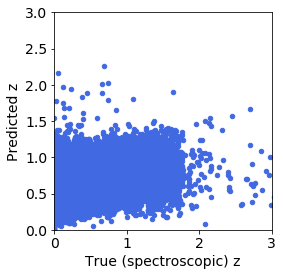

In [19]:
plt.scatter(target,ypred, s = 20, c = 'royalblue')
plt.xlabel('True (spectroscopic) z', fontsize=14)
plt.ylabel('Predicted z',fontsize=14)
plt.axis('square')
plt.xlim(0,3)
plt.ylim(0,3)

### Question: Does it look like the one of the paper?

For a fair comparison, we can calculate the outlier fraction, like in the paper:

In [20]:
len(np.where(np.abs(target-ypred)>0.15*(1+target))[0])/len(target)

0.2574091176223659

And the normalized median absolute deviation, or NMAD:

In [21]:
1.48*np.median(np.abs(target-ypred)/(1 + target)) 
#The 1.48 is there because for a Gaussian distribution, this becomes the standard deviation

0.07454620816448053

#### We have a pretty severe high variance issue; let's see if parameter optimization helps.

We can start by making the data set a bit smaller, as we have seen that timings were already challenging in simple k-fold CV.

In [22]:
np.random.seed(20)
sel = np.random.choice(range(len(ypred)), 5000, replace = False) #sample without replacement

In [23]:
len(np.unique(sel))

5000

And we create our new smaller data set.

In [24]:
seld = features.loc[sel,:]
selt = target[sel]

In [25]:
littlescores = cross_validate(model,seld,selt, cv = KFold(n_splits=5, shuffle=True, random_state=10), return_train_score=True)

In [26]:
littlescores['test_score'].mean(), littlescores['train_score'].mean()

(0.2776271514859994, 0.8763722033397615)

Similar performance on training set ensures that size of data set is not a big issue and we can proceed with optimization.

The parameters that we can consider varying include:

#### Tree Parameters

-  The minimum number of instances in a leaf node;

-  The minimum number of instances required to create a new split;

- The maximum depth of tree;

-  The criterion chosen to decide whether a split is worth making, expressed in terms of information gain;


#### Randomization Parameters

- The number of k < n features that are used to build trees.

- The re-sampling (boostrap) of the data set (T or F).


#### Forest Parameters

The number of trees in the forest (n_estimators) can be adjusted, with the general understanding that more trees are better, but at some point performance will plateau, so one can find the trade-off between having more trees and lower runtime.

We can find them here:

In [27]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Let's discuss a possible set.

In [ ]:
try maxdepth not None; min_samples_split > 2; increase n_estimators; max_features













The cell below creates a grid of parameters and runs a cross-validated model for every possible combination, and returns the best-performing model. It gets time-consuming quite fast.

In [28]:
#Takes a few minutes

parameters = {'max_depth':[None, 3, 6], \
              'min_samples_split':[2, 10, 20], 'n_estimators':[100,200], 'max_features': ['auto',4]}

nmodels = np.product([len(el) for el in parameters.values()])

model = GridSearchCV(RandomForestRegressor(), parameters, \
                     cv = KFold(n_splits=5, shuffle=True), \
                     verbose = 2, n_jobs = 4, return_train_score=True)

model.fit(seld,selt)

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/usr/local/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best params, best score: 0.2938 {'max_depth': None, 'max_features': 4, 'min_samples_split': 10, 'n_estimators': 200}


We can save the scores in a data frame and sort them by decreasing test scores (so our top performing model is first).

In [29]:
scores = pd.DataFrame(model.cv_results_)

scoresCV = scores[['params','mean_test_score','std_test_score','mean_train_score']].sort_values(by = 'mean_test_score', \
                                                    ascending = False)


In [30]:
scoresCV

,params,mean_test_score,std_test_score,mean_train_score
9,"{'max_depth': None, 'max_features': 4, 'min_samples_split': 10, 'n_estimators': 200}",0.293771,0.021616,0.752936
10,"{'max_depth': None, 'max_features': 4, 'min_samples_split': 20, 'n_estimators': 100}",0.292644,0.016898,0.650346
11,"{'max_depth': None, 'max_features': 4, 'min_samples_split': 20, 'n_estimators': 200}",0.292304,0.020333,0.651982
8,"{'max_depth': None, 'max_features': 4, 'min_samples_split': 10, 'n_estimators': 100}",0.291224,0.019522,0.749815
2,"{'max_depth': None, 'max_features': 'auto', 'min_samples_split': 10, 'n_estimators': 100}",0.287950,0.020264,0.762267
5,"{'max_depth': None, 'max_features': 'auto', 'min_samples_split': 20, 'n_estimators': 200}",0.287812,0.018285,0.667054
3,"{'max_depth': None, 'max_features': 'auto', 'min_samples_split': 10, 'n_estimators': 200}",0.286358,0.020594,0.764621
7,"{'max_depth': None, 'max_features': 4, 'min_samples_split': 2, 'n_estimators': 200}",0.285769,0.024337,0.878648
4,"{'max_depth': None, 'max_features': 'auto', 'min_samples_split': 20, 'n_estimators': 100}",0.285397,0.015890,0.666852
6,"{'max_depth': None, 'max_features': 4, 'min_samples_split': 2, 'n_estimators': 100}",0.284373,0.022578,0.877237


### And the verdict is....

Our model is still performing poorly.




















### Challenge: can you use some of the things we learned, the paper, and your own knowledge (possibly) to match the paper's results?



Ideas:

- Feature engineering: from magnitudes to colors 

- Adding other features from data
    
- Decide what to do with missing data (99s and -99s)

- Restrict the redshift range

- (Check the paper for other ideas)

? 
    

### Time to look at data cleaning and/or imputing!

We begin by selecting only objects where the zquality flag is >= 3 (as noted in Section 6 of the paper).

In [89]:
mags = df[['u_apercor', 'g_apercor', 'r_apercor', 'i_apercor', 'z_apercor','y_apercor','zquality','cfhtls_source']]

In [90]:
mags = mags[mags['zquality'] >= 3]

mags.shape

(16857, 8)

This reduces the data set size by one third.

Next, we select only objects where all columns contain a measurement (we exclude the 99s and -99s). This was also done in the paper (first paragraph of page 10: Valid photometry in all six bands
(ugrizY) is required). This reduced the size of the data set to half.

In [91]:
mags = mags[mags > -10].dropna()
mags = mags[mags < 90].dropna()

In [92]:
mags.shape

(8508, 8)

This would already be sufficient for good results. However, in figure we are looking at the paper (Fig. 6), only objects with deep cfhtls photometry are used:

In [93]:
mags = mags[mags['cfhtls_source'] == 0]

In [94]:
mags.shape

(6307, 8)

Our final set has 6,307 objects.

Finally, we engineer colors as features. In the paper, 5 colors and the i magnitude are used). However, we can improve more by building all the colors. We will run the two cases for comparison.

This cell (thanks to Michael Rashkovetskyi) builds all the colors.

In [111]:
params = ['u_apercor', 'g_apercor', 'r_apercor', 'i_apercor', 'z_apercor','y_apercor']
features_ext = mags.copy()
for i, name1 in enumerate(params):
    for j, name2 in enumerate(params):
        if i >=j: continue #build only one pair, avoid zero colors
        features_ext[name1 + '-' + name2] = features[name1] - features[name2]

In [112]:
features_ext.head()

,u_apercor,g_apercor,r_apercor,i_apercor,z_apercor,y_apercor,zquality,cfhtls_source,u_apercor-g_apercor,u_apercor-r_apercor,u_apercor-i_apercor,u_apercor-z_apercor,u_apercor-y_apercor,g_apercor-r_apercor,g_apercor-i_apercor,g_apercor-z_apercor,g_apercor-y_apercor,r_apercor-i_apercor,r_apercor-z_apercor,r_apercor-y_apercor,i_apercor-z_apercor,i_apercor-y_apercor,z_apercor-y_apercor
1251,24.244393,23.979583,23.522136,22.911041,22.525773,22.329098,4,0.0,0.264811,0.722258,1.333352,1.718620,1.915295,0.457447,1.068542,1.453810,1.650485,0.611094,0.996362,1.193037,0.385268,0.581943,0.196675
1253,24.489104,23.916151,22.923651,21.873752,21.306495,21.251440,4,0.0,0.572953,1.565453,2.615352,3.182610,3.237664,0.992500,2.042399,2.609656,2.664711,1.049899,1.617157,1.672212,0.567258,0.622312,0.055055
1261,24.873959,22.973893,21.465850,20.788420,20.462283,20.413696,3,0.0,1.900066,3.408108,4.085538,4.411676,4.460262,1.508042,2.185473,2.511610,2.560196,0.677430,1.003568,1.052154,0.326138,0.374724,0.048586
1271,24.529042,24.338631,23.891189,23.206102,22.989344,23.112382,4,0.0,0.190411,0.637853,1.322940,1.539698,1.416661,0.447442,1.132529,1.349287,1.226250,0.685087,0.901845,0.778808,0.216758,0.093721,-0.123037
1272,23.641180,23.387447,22.975301,22.235199,21.809658,21.559483,4,0.0,0.253733,0.665879,1.405981,1.831522,2.081697,0.412146,1.152248,1.577789,1.827964,0.740102,1.165643,1.415818,0.425541,0.675717,0.250175


We have now added 16 more features!

We can re-index the target vector by matching the indices of the selected objects.

In [100]:
target = target[features_ext.index]

Let's now run our benchmark model again. Let's start from the exact features of the paper.

In [108]:
model = RandomForestRegressor()

In [113]:
#The five colors u − g, g − r, r − i, i − z, z − y and
#-band magnitude are used as the input.

features_paper = features_ext[['u_apercor-g_apercor','g_apercor-r_apercor', \
            'r_apercor-i_apercor','i_apercor-z_apercor','z_apercor-y_apercor','i_apercor']]

In [114]:
scores = cross_validate(model, features_paper, target, cv = KFold(n_splits=5,shuffle=True),return_train_score=True)

In [115]:
print(scores['test_score'].mean(), scores['train_score'].mean())

0.8143781470556807 0.9716063430592918


This is a very noticeable improvement! Let's also plot the true vs predicted redshifts, and calculate the outlier fraction and NMAD.

In [116]:
ypred = cross_val_predict(model,features_ext,target, \
        cv = KFold(n_splits=5, shuffle=True, random_state=10))

(0, 3)

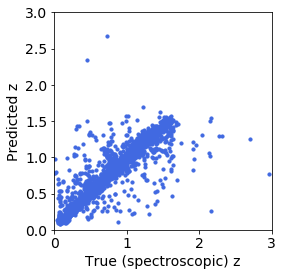

In [117]:
plt.scatter(target,ypred, s = 10, c = 'royalblue')
plt.xlabel('True (spectroscopic) z', fontsize=14)
plt.ylabel('Predicted z',fontsize=14)
plt.axis('square')
plt.xlim(0,3)
plt.ylim(0,3)

In [118]:
len(np.where(np.abs(target-ypred)>0.15*(1+target))[0])/len(target)

0.036467417155541464

And the normalized median absolute deviation, or NMAD:

In [119]:
1.48*np.median(np.abs(target-ypred)/(1 + target)) 
#The 1.48 is there because for a Gaussian distribution, this becomes the standard deviation

0.01659259302277249

#### Yay! We have already matched (and in fact, improved on) the paper!

We may want to run the param optimization again. 

In [123]:
parameters = {'max_depth':[3, 6, None], \
              'max_features':[2,4,None], 'n_estimators':[50,100,200], 'min_samples_leaf': [1,5,10]}
nmodels = np.product([len(el) for el in parameters.values()])
model = GridSearchCV(RandomForestRegressor(), parameters, cv = KFold(n_splits=5, shuffle=True), \
                     verbose = 2, n_jobs = 4, return_train_score=True)
model.fit(features_paper, target)

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


/usr/local/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best params, best score: 0.8112 {'max_depth': None, 'max_features': 2, 'min_samples_leaf': 1, 'n_estimators': 100}


In [125]:
bm = model.best_estimator_

In [126]:
ypred = cross_val_predict(bm, features_paper,target, \
        cv = KFold(n_splits=5, shuffle=True, random_state=10))

(0, 2)

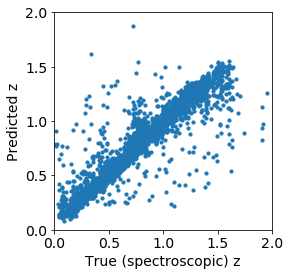

In [127]:
plt.scatter(target,ypred, s = 10)
plt.xlabel('True (spectroscopic) z', fontsize=14)
plt.ylabel('Predicted z',fontsize=14)
plt.axis('square')
plt.xlim(0,2)
plt.ylim(0,2)

In [128]:
## OLF

len(np.where(np.abs(target-ypred)>0.15*(1+target))[0])/len(target)

0.03710163310607262

And the normalized median absolute deviation, or NMAD:

In [129]:
#NMAD

1.48*np.median(np.abs(target-ypred)/(1 + target)) 

0.01902204930915988

Note that (for my particular case; if the random seed is not fixed, you may get something different) while the R2 score for the "best" model is higher, the OLF and NMAD are actually a bit higher than our benchmark model, the one with default parameters. This is fine, but we could also define a custom scoring parameter to use in the "GridSearchCV" object, for example the NMAD, so that models are scored and sorted according to the lowest NMAD.

Finally, we can explore whether using the full set of colors can help us further improve. We begin by running a benchmark model on the full set of features.

In [131]:
model = RandomForestRegressor()

In [132]:
scores = cross_validate(model, features_ext, target, cv = KFold(n_splits=5,shuffle=True),return_train_score=True)

print(scores['test_score'].mean(), scores['train_score'].mean())

0.803603153115825 0.9722250799987876


It looks like adding more features doesn't help the benchmark, but in general, optimization matters more for more complex models.

Let's take a look at the other metrics, and then run the optimization.

In [134]:
ypred = cross_val_predict(bm, features_ext,target, \
        cv = KFold(n_splits=5, shuffle=True, random_state=10))

In [135]:
## OLF

len(np.where(np.abs(target-ypred)>0.15*(1+target))[0])/len(target)

0.03662597114317425

And the normalized median absolute deviation, or NMAD:

In [136]:
#NMAD

1.48*np.median(np.abs(target-ypred)/(1 + target)) 

0.022319697289802036

The NMAD is actually a bit larger for this model.

Finally, we can run the param optimization again, but it will take longer because we have more features.

In [137]:
parameters = {'max_depth':[3, 6, None], \
              'max_features':['auto',10,None], 'n_estimators':[50,100,200], 'min_samples_leaf': [1,5,10]}
nmodels = np.product([len(el) for el in parameters.values()])
model = GridSearchCV(RandomForestRegressor(), parameters, cv = KFold(n_splits=5, shuffle=True), \
                     verbose = 2, n_jobs = 4, return_train_score=True)
model.fit(features_ext, target)

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


/usr/local/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best params, best score: 0.8261 {'max_depth': None, 'max_features': 10, 'min_samples_leaf': 1, 'n_estimators': 100}


The R2 score improves for the best model! Let's check what happens to the other metrics.

In [138]:
bm = model.best_estimator_

In [139]:
ypred = cross_val_predict(bm, features_ext,target, \
        cv = KFold(n_splits=5, shuffle=True, random_state=10))

In [141]:
## OLF

len(np.where(np.abs(target-ypred)>0.15*(1+target))[0])/len(target)

0.035674647217377516

And the normalized median absolute deviation, or NMAD:

In [142]:
#NMAD

1.48*np.median(np.abs(target-ypred)/(1 + target)) 

0.017264785172619874

These are also pretty good; better than the paper, and similar to what our simpler model with 5 colors + i magnitude can achieve.

There were other ideas proposed in the hack session that we didn't have time to explore: Data augmentation (e.g. creating additional samples by associating an error profile to each measurement and sampling from that, while keeping the redshifts fixed; dividing the data in bins in redshift).

### Lessons learned

Here are my takeaways from this exercise:

Data cleaning and imputing >> model optimization 

Feature engineering and domain knowledge >> model optimization

ML won't make us obsolete (yet)! But it's a fun way to explore hypotheses and test them with data.